In [6]:
# Authors: Murat Cihan Sorkun <mcsorkun@gmail.com>, Dajt Mullaj <dajt.mullai@gmail.com>
#
# License: BSD 3 clause 
from __future__ import print_function
import descriptors as desc
import parameters as parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import base64
import functools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from pandas.api.types import is_numeric_dtype
from rdkit.Chem import Draw
from bokeh.plotting import figure
from bokeh.transform import transform, factor_cmap
from bokeh.palettes import Category10, Inferno, Spectral4
from bokeh.models.mappers import LinearColorMapper
from bokeh.models import ColorBar, HoverTool, Panel, Tabs
from bokeh.io import output_file, save, show
from scipy import stats
from io import BytesIO

def calltracker(func):
    @functools.wraps(func)
    def wrapper(*args):
        wrapper.has_been_called = True
        return func(*args)
    wrapper.has_been_called = False
    return wrapper

class Plotter(object):
    """
    A class used to plot the ECFP fingerprints of the molecules used to 
    instantiate it.
    
    :param __sim_type: similarity type structural or tailored
    :param __target_type: target type R (regression) or C (classificatino)
    :param __target: list containing the target values. Is empty if a target does not exist
    :param __mols: list of valid molecules that can be plotted
    :param __df_descriptors: datatframe containing the descriptors representation of each molecule
    :param __df_2_components: dataframe containing the two-dimenstional representation of each molecule
    :param __plot_title: title of the plot reflecting the dimensionality reduction algorithm used
    :param __data: list of the scaled descriptors to which the dimensionality reduction algorithm is applied
    :param pca_fit: PCA object created when the corresponding algorithm is applied to the data
    :param tsne_fit: t-SNE object created when the corresponding algorithm is applied to the data
    :param umap_fit: UMAP object created when the corresponding algorithm is applied to the data
    :param df_plot_xy: dataframe containing the coordinates that have been plotted
    :type __sim_type: string
    :type __target_type: string
    :type __target: list
    :type __mols: rdkit.Chem.rdchem.Mol
    :type __df_descriptors: Dataframe
    :type __df_2_components: Dataframe
    :type __plot_title: string
    :type __data: list
    :type pca_fit: sklearn.decomposition.TSNE
    :type tsne_fit: sklearn.manifold.TSNE
    :type umap_fit: umap.umap_.UMAP
    :type df_plot_xy: Dataframe
    """
       
    _static_plots = {'scatter', 'hex', 'kde'}
    
    _interactive_plots = {'scatter', 'hex'}
    
    _sim_types = {'tailored', 'structural'}
    
    _target_types = {'R', 'C'}

    def __init__(self, encoding_list, target, target_type, sim_type, get_desc, get_fingerprints):
           
        # Error handeling sym_type
        if sim_type not in self._sim_types:
            if len(target) > 0:
                self.__sim_type = 'tailored' 
                print('sim_type indicates the similarity type by which the plots are constructed.\n' +
                      'The supported similarity types are structural and tailored.\n' +
                      'Because a target list has been provided \'tailored\' as been selected as sym_type.')
            else: 
                self.__sim_type = 'structural' 
                print('sim_type indicates the similarity type by which the plots are constructed.\n' +
                      'The supported similarity types are structural and tailored.\n' +
                      'Because no target list has been provided \'structural\' as been selected as sym_type.')
        else:
            self.__sim_type = sim_type
         
        if self.__sim_type != "structural" and len(target) == 0:
            raise Exception("Target values missing")
        
        # Error handeling target_type                
        if len(target) > 0:
            if len(target) != len(encoding_list):
                raise Exception("If target is provided its length must match the instances of molecules")
                
        if len(target) > 0:
            df_target = pd.DataFrame(data=target)
            unique_targets_ratio = 1.*df_target.iloc[:, 0].nunique()/df_target.iloc[:, 0].count() < 0.05
            numeric_target = is_numeric_dtype(df_target.dtypes[0])
            if target_type == 'R' and (unique_targets_ratio or not numeric_target):
                print('Input received is \'R\' for target values that seem not continuous.')
            if target_type not in self._target_types:
                if not unique_targets_ratio and numeric_target:
                    self.__target_type = 'R'
                    print('target_type indicates if the target is a continuous variable or a class label.\n'+
                          'R stands for regression and C for classification. Input R as target type for continuous variables and C for class labels.\n'+
                          'From analysis of the target, R has been selected for target_type.')
                else:
                    self.__target_type = 'C'
                    print('target_type indicates if the target is a continuous variable or a class label.\n'+
                          'R stands for regression and C for classification. Input R as target type for continuous variables and C for class labels.\n'+
                          'From analysis of the target, C has been selected for target_type.')
            else:
                self.__target_type = target_type
        else:
            self.__target_type = None
        
        if len(target) > 0 and self.__target_type == 'C':
            df_target = pd.DataFrame(data=target)
            if df_target.iloc[:, 0].nunique() == 1:
                target = []
                self.__sim_type = "structural"
                print("Only one class found in the targets")
          
        # Instantiate Plotter class
        if self.__sim_type == "tailored":
            self.__mols, df_descriptors, target = get_desc(encoding_list, target)
            if df_descriptors.empty:
                raise Exception("Descriptors could not be computed for given molecules")
            self.__df_descriptors, self.__target = desc.select_descriptors_lasso(df_descriptors,target,kind=self.__target_type)
        elif self.__sim_type == "structural":
            self.__mols, self.__df_descriptors, self.__target = get_fingerprints(encoding_list,target,2,2048)
            
        if len(self.__mols) < 2 or len(self.__df_descriptors.columns) < 2:
            raise Exception("Plotter object cannot be instantiated for given molecules")
                
        self.__df_2_components = None
        self.__plot_title = None
            
    
    @classmethod        
    def from_smiles(cls, smiles_list, target=[], target_type=None, sim_type=None):
        """
        Class method to construct a Plotter object from a list of SMILES.
        
        :param smile_list: List of the SMILES representation of the molecules to plot.       
        :param target: target values       
        :param target_type: target type R (regression) or C (classificatino)      
        :param sim_type: similarity type structural or tailored     
        :type smile_list: list
        :type target: list
        :type target_type: string
        :type sim_type: string
        :returns: A Plotter object for the molecules given as input.
        :rtype: Plotter
        """
            
        return cls(smiles_list, target, target_type, sim_type, desc.get_mordred_descriptors, desc.get_ecfp)
            

    @classmethod
    def from_inchi(cls, inchi_list, target=[], target_type=None, sim_type=None):
        """
        Class method to construct a Plotter object from a list of InChi.
        
        :param inchi_list: List of the InChi representation of the molecules to plot.
        :type inchi_list: dict
        :param target: target values
        :type target: dict
        :param target_type: target type R (regression) or C (classificatino)
        :type target_type: string
        :param sim_type: similarity type structural or tailored 
        :type sim_type: string
        :returns: A Plotter object for the molecules given as input.
        :rtype: Plotter
        """
                
        return cls(inchi_list, target, target_type, sim_type, desc.get_mordred_descriptors_from_inchi, desc.get_ecfp_from_inchi)
        
    
    def pca(self, **kwargs):
        """
        Calculates the first 2 PCA components of the molecular descriptors.
        
        :param kwargs: Other keyword arguments are passed down to sklearn.decomposition.PCA
        :type kwargs: key, value mappings
        :returns: The dataframe containing the PCA components.
        :rtype: Dataframe
        """
        self.__data = self.__data_scaler()
        
        # Linear dimensionality reduction to 2 components by PCA
        self.pca_fit = PCA(n_components=2, **kwargs)
        first2ecpf_components = self.pca_fit.fit_transform(self.__data)
        coverage_components = self.pca_fit.explained_variance_ratio_
        
        # Create labels for the plot
        first_component = "PC-1 (" + "{:.0%}".format(coverage_components[0]) + ")"
        second_component = "PC-2 (" + "{:.0%}".format(coverage_components[1]) + ")"
        # Create a dataframe containinting the first 2 PCA components of ECFP 
        self.__df_2_components = pd.DataFrame(data = first2ecpf_components
             , columns = [first_component, second_component])
        
        self.__plot_title = "PCA plot"
        
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
    
    
    def tsne(self, perplexity=None, pca=False, random_state=None, **kwargs):
        """
        Calculates the first 2 t-SNE components of the molecular descriptors.
        
        :param perplexity: perplexity value for the t-SNE model  
        :param pca: indicates if the features must be preprocessed by PCA
        :param random_state: random seed that can be passed as a parameter for reproducing the same results     
        :param kwargs: Other keyword arguments are passed down to sklearn.manifold.TSNE
        :type perplexity: int
        :type pca: boolean
        :type random_state: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the t-SNE components.
        :rtype: Dataframe
        """ 
        self.__data = self.__data_scaler()
        self.__plot_title = "T-Distributed Stochastic Neighbor Embedding"
        
        # Preprocess the data with PCA
        if pca and self.__sim_type == "structural":
            pca = PCA(n_components=10, random_state=random_state)
            self.__data = pca.fit_transform(self.__data)
            self.__plot_title = "t-SNE plot from components with cumulative variance explained " + "{:.0%}".format(sum(pca.explained_variance_ratio_))
        else:
            self.__plot_title = "t-SNE plot"
        
        # Get the perplexity of the model
        if perplexity is None:
            if self.__sim_type == "structural":
                if pca:
                    perplexity = parameters.perplexity_structural_pca(len(self.__data))
                else:
                    perplexity = parameters.perplexity_structural(len(self.__data))
            else:
                perplexity = parameters.perplexity_tailored(len(self.__data))
        else:
            if perplexity<5 or perplexity>50:
                print('Robust results are obtained for values of perplexity between 5 and 50')
        
        # Embed the data in two dimensions
        self.tsne_fit = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, **kwargs)
        ecfp_tsne_embedding = self.tsne_fit.fit_transform(self.__data)
        # Create a dataframe containinting the first 2 TSNE components of ECFP 
        self.__df_2_components = pd.DataFrame(data = ecfp_tsne_embedding
             , columns = ['t-SNE 1st Dimension', 't-SNE 2nd Dimension'])
            
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
        
        
    def umap(self, n_neighbors=None, min_dist=None, pca=False, random_state=None, **kwargs):
        """
        Calculates the first 2 UMAP components of the molecular descriptors.
        
        :param num_neighbors: Number of neighbours used in the UMAP madel.
        :param min_dist: Value between 0.0 and 0.99, indicates how close to each other the points can be displayed.
        :param random_state: random seed that can be passed as a parameter for reproducing the same results
        :param kwargs: Other keyword arguments are passed down to umap.UMAP
        :type num_neighbors: int
        :type min_dist: float
        :type random_state: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the UMAP components.
        :rtype: Dataframe
        """  
        self.__data = self.__data_scaler()
        
        # Preprocess the data with PCA
        if pca and self.__sim_type == "structural":
            pca = PCA(n_components=10, random_state=random_state)
            self.__data = pca.fit_transform(self.__data)
            self.__plot_title = "UMAP plot from components with cumulative variance explained " + "{:.0%}".format(sum(pca.explained_variance_ratio_))
        else:
            self.__plot_title = "UMAP plot"
        
        if n_neighbors is None:
            if self.__sim_type == "structural":
                if pca:
                    n_neighbors = parameters.n_neighbors_structural_pca(len(self.__data))
                else:
                    n_neighbors = parameters.n_neighbors_structural(len(self.__data))
            else:
                n_neighbors = parameters.n_neighbors_tailored(len(self.__data))
                
        if min_dist is None or min_dist < 0.0 or min_dist > 0.99:
            if min_dist is not None and (min_dist < 0.0 or min_dist > 0.99):
                print('min_dist must range from 0.0 up to 0.99. Default used.')
            if self.__sim_type == "structural":
                if pca:
                    min_dist = parameters.MIN_DIST_STRUCTURAL_PCA
                else:
                    min_dist = parameters.MIN_DIST_STRUCTURAL
            else:
                min_dist = parameters.MIN_DIST_TAILORED
            
        # Embed the data in two dimensions
        self.umap_fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_components=2, **kwargs)
        ecfp_umap_embedding = self.umap_fit.fit_transform(self.__data)
        # Create a dataframe containinting the first 2 UMAP components of ECFP 
        self.__df_2_components = pd.DataFrame(data = ecfp_umap_embedding
             , columns = ['UMAP-1', 'UMAP-2'])
        
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
    
    
    def cluster(self, n_clusters=5, **kwargs):
        """
        Computes the clusters presents in the embedded chemical space.
        
        :param n_clusters: Number of clusters that will be computed  
        :param kwargs: Other keyword arguments are passed down to sklearn.cluster.KMeans
        :type n_clusters: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the 2D embedding.
        :rtype: Dataframe
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before clustering.')
            return None
        
        x = self.__df_2_components.columns[0]
        y = self.__df_2_components.columns[1]
        
        cluster = KMeans(n_clusters, **kwargs)
        
        cluster.fit(self.__df_2_components[[x,y]])
        self.__df_2_components['clusters'] = cluster.labels_.tolist()
        
        return self.__df_2_components.copy()
    
    
    def visualize_plot(self, size=20, kind="scatter", remove_outliers=False, is_colored=True, colorbar=False, clusters=False, filename=None, title=None):
        """
        Generates a plot for the given molecules embedded in two dimensions.
        
        :param size: Size of the plot  
        :param kind: Type of plot 
        :param remove_outliers: Boolean value indicating if the outliers must be identified and removed 
        :param is_colored: Indicates if the points must be colored according to target 
        :param colorbar: Indicates if the plot legend must be represented as a colorbar. Only considered when the target_type is "R".
        :param clusters: If True the clusters are shown instead of possible targets. Pass a list or a int to only show selected clusters (indexed by int).
        :param filename: Indicates the file where to save the plot
        :param title: Title of the plot.
        :type size: int
        :type kind: string
        :type remove_outliers: boolean
        :type is_colored: boolean
        :type colorbar: boolean
        :type clusters: boolean or list or int
        :type filename: string
        :type title: string
        :returns: The matplotlib axes containing the plot.
        :rtype: Axes
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before creating a plot.')
            return None
        
        if clusters is not False and 'clusters' not in self.__df_2_components:
            print('Call cluster() before visualizing a plot with clusters.')
        
        if title is None:
            title = self.__plot_title
        
        if kind not in self._static_plots:
            kind = 'scatter'
            print('kind indicates which type of plot must be visualized. Currently supported static visualization are:\n'+
                  '-scatter plot (scatter)\n'+
                  '-hexagon plot (hex)\n'+
                  '-kernel density estimation plot (kde)\n'+
                  'Please input one between scatter, hex or kde for parameter kind.\n'+
                  'As default scatter has been taken.')
            
        x, y, df_data = self.__parse_dataframe()
        
        # Define colors 
        hue = None
        hue_order = None
        palette = None
        if clusters is not False and 'clusters' in self.__df_2_components.columns:
            hue = 'clusters'
            palette = 'deep'
            if not isinstance(clusters, bool):
                if isinstance(clusters, int): clusters = [clusters]
                df_data['clusters'] = df_data['clusters'].isin(clusters)
                # Labels cluster
                total = df_data['clusters'].value_counts()
                t_s = total.get(True) if total.get(True) else 0
                p_s = t_s / total.sum()
                p_o = 1 - p_s
                labels = {
                    True: f'Selected - {p_s:.0%}', 
                    False: f'Other - {p_o:.0%}'
                    }
                df_data.clusters.replace(labels, inplace=True)
                hue_order = list(labels.values())
            else:
                hue_order = self.__percentage_clusters(df_data)
                hue_order.sort()
        else:
            if len(self.__target) == 0:
                is_colored = False;
            else:
                if is_colored:
                    df_data = df_data.assign(target=self.__target)
                    hue = 'target'
                    palette = 'deep'
                    if self.__target_type == "R":
                        palette = sns.color_palette("inferno", as_cmap=True)
                        
        
        # Remove outliers (using Z-score)
        if remove_outliers:
            df_data = self.__remove_outliers(x, y, df_data)
            
        # Define plot aesthetics parameters
#         sns.set_style("dark")
        sns.set(style='ticks')
        sns.set_context("notebook", font_scale=size*0.15)
        fig, ax = plt.subplots(figsize=(size,size))
        
        
        palette = 'Paired_r'
        # Create a plot based on the reduced components 
        if kind == "scatter":
#             plot = sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, palette=palette, data=df_data, s=size*3,alpha = .9)
            plot = sns.scatterplot(x=x, y=y, 
            hue=hue, 
            data=df_data,
            s=300,
            alpha=.6, 
            palette='muted')
            plot.set_label("scatter")
            axis = plot
            plot.legend(markerscale=size*0.19,loc = 'upper right')
            # Add colorbar
            if self.__target_type == "R" and colorbar:
                plot.get_legend().remove()
                norm = plt.Normalize(df_data['target'].min(), df_data['target'].max())
                cm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
                cm.set_array([])
                plot.figure.colorbar(cm)
        elif kind == "hex":
            plot = ax.hexbin(df_data[x], df_data[y], gridsize=40, cmap='Blues')
            fig.colorbar(plot, ax=ax)
            ax.set_label("hex")
            axis = ax
        elif kind == "kde":
            plot = sns.kdeplot(x=x, y=y, shade=True, data=df_data)
            plot.set_label("kde")
            axis = plot
             
        # Remove units from axis
        axis.set(yticks=(-80,-40,0,40,80))
        axis.set(xticks=(-80,-40,0,40,80))
        # Add labels
        axis.set_title(title,fontsize=size*2,fontweight ='bold')
        axis.set_xlabel(x,fontsize=size*2,fontweight ='bold')
        axis.set_ylabel(y,fontsize=size*2,fontweight ='bold')
        
        # Save plot
        if filename is not None:
            fig.savefig(filename)
            
        self.df_plot_xy = df_data[[x,y]]
        
        return axis
    
    def interactive_plot(self, size=700, kind="scatter", remove_outliers=False, is_colored=True, clusters=False, filename=None, show_plot=False, title=None,):
        """
        Generates an interactive Bokeh plot for the given molecules embedded in two dimensions.
        
        :param size: Size of the plot  
        :param kind: Type of plot 
        :param remove_outliers: Boolean value indicating if the outliers must be identified and removed 
        :param is_colored: Indicates if the points must be colored according to target 
        :param clusters: Indicates if to add a tab with the clusters if these have been computed
        :param filename: Indicates the file where to save the Bokeh plot
        :param show_plot: Immediately display the current plot. 
        :param title: Title of the plot.
        :type size: int
        :type kind: string
        :type remove_outliers: boolean
        :type is_colored: boolean
        :type cluster: boolean
        :type filename: string
        :type show_plot: boolean
        :type title: string
        :returns: The bokeh figure containing the plot.
        :rtype: Figure
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before creating a plot.')
            return None
        
        if clusters and 'clusters' not in self.__df_2_components:
            print('Call cluster() before visualizing a plot with clusters.')
            
        if title is None:
            title = self.__plot_title
        
        if kind not in self._interactive_plots:
            kind = 'scatter'
            print('kind indicates which type of plot must be visualized. Currently supported interactive visualization are:\n'+
                  '-scatter plot (scatter)\n'+
                  '-hexagon plot (hex)\n'+
                  'Please input one between scatter, hex or kde for parameter kind.\n'+
                  'As default scatter has been taken.')
            
        x, y, df_data = self.__parse_dataframe()
        df_data['mols'] = self.__mols
        
        if len(self.__target) > 0:
            # Target exists
            if self.__target_type == 'C':
                df_data['target'] = list(map(str, self.__target))
            else:
                df_data['target'] = self.__target
            
        # Remove outliers (using Z-score)
        if remove_outliers:
            df_data = self.__remove_outliers(x, y, df_data)
        
        tabs = None
        if kind == "scatter":
            p, tabs = self.__interactive_scatter(x, y, df_data, size, is_colored, clusters, title)
        else: 
            p = self.__interactive_hex(x, y, df_data, size, title)
            
        p.xaxis[0].axis_label = x
        p.yaxis[0].axis_label = y
        
        p.xaxis.major_tick_line_color = None  
        p.xaxis.minor_tick_line_color = None
        p.yaxis.major_tick_line_color = None  
        p.yaxis.minor_tick_line_color = None 
        p.xaxis.major_label_text_font_size = '0pt'  
        p.yaxis.major_label_text_font_size = '0pt' 
        
        if tabs is not None:
            p = tabs
            
        # Save plot
        if filename is not None:
            output_file(filename, title=title)
            save(p)
        
        # Show plot
        if show_plot:
            self.__open_plot(p)
                        
        self.df_plot_xy = df_data[[x,y]]
        
        return p
    
    def __data_scaler(self):
        # Scale the data
        if self.__sim_type != "structural":
            scaled_data = StandardScaler().fit_transform(self.__df_descriptors.values.tolist())
        else:
            scaled_data = self.__df_descriptors.values.tolist()
            
        return scaled_data
    
    def __parse_dataframe(self):
        x = self.__df_2_components.columns[0]
        y = self.__df_2_components.columns[1]
        
        return x, y, self.__df_2_components.copy()
    
    def __remove_outliers(self, x, y, df):
        # Remove outliers (using Z-score)
        z_scores = stats.zscore(df[[x,y]])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 3).all(axis=1)
        
        return df[filtered_entries]
    
    def __percentage_clusters(self, df_data):
        total = df_data['clusters'].value_counts()
        sum_tot = total.sum()
        labels = {}
        count = 0
        for key, value in total.items():
            p = float(f"{(value/sum_tot)*100:.0f}")
            labels[key] = p
            count += p
        # Solve possible rounding errors
        if 100 - count > 0:
            labels[0] = labels[0] + 100 - count
        for key, value in labels.items():
            labels[key] = f"Cluster {key} - {value:.0f}%"
        # Edit df_data and return labels
        df_data.clusters.replace(labels, inplace=True)
        return list(labels.values())
            
    def __interactive_scatter(self, x, y, df_data, size, is_colored, clusters, title):       
        # Add images column
        df_data['imgs'] = self.__mol_to_2Dimage(list(df_data['mols']))
        df_data.drop(columns=['mols'], inplace=True)
        # Set tools
        tools = "pan, lasso_select, wheel_zoom, hover, save, reset"
        
        if len(self.__target) == 0:
            TOOLTIPS = parameters.TOOLTIPS_NO_TARGET
        else:
            TOOLTIPS = parameters.TOOLTIPS_TARGET

        # Create plot
        p = figure(title=title, plot_width=size, plot_height=size, tools=tools, tooltips=TOOLTIPS)
        
        if len(self.__target) == 0 or not(is_colored):
            p.circle(x=x, y=y, size=2.5, alpha=0.8, source=df_data)
        else:
            # Target exists
            if self.__target_type == 'C':
                index_cmap = factor_cmap('target', Category10[10], list(set(df_data['target'])))
                p.circle(x=x, y=y, size=2.5, alpha=0.8, line_color=index_cmap, fill_color=index_cmap,
                     legend_group="target", source=df_data)
                p.legend.location = "top_left"
                p.legend.title = "Target"
            else:
                color_mapper = LinearColorMapper(Inferno[256], low=min(df_data['target']), high=max(df_data['target']))
                index_cmap = transform('target', color_mapper)
                p.circle(x=x, y=y, size=2.5, alpha=0.8, line_color=index_cmap, fill_color=index_cmap,
                     source=df_data)
                color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
                p.add_layout(color_bar, 'right')
        
        tabs = None
        if clusters and 'clusters' in df_data.columns:
            p_c = figure(title=title, plot_width=size, plot_height=size, tools=tools, tooltips=parameters.TOOLTIPS_CLUSTER)
            # Get percentages
            self.__percentage_clusters(df_data)
            clusters = df_data.groupby(['clusters'])
            for cluster, color in zip(clusters, Category10[10]):
                p_c.circle(x=x, y=y, size=2.5, alpha=1, line_color=color, fill_color=color,
                     legend_label=f'{cluster[0]}', muted_color=('#717375'), muted_alpha=0.2,
                     source=cluster[1])
                
            p_c.legend.location = "top_left"
            p_c.legend.title = "Clusters"
            p_c.legend.click_policy = "mute"
            
            p_c.xaxis[0].axis_label = x
            p_c.yaxis[0].axis_label = y
            
            p_c.xaxis.major_tick_line_color = None  
            p_c.xaxis.minor_tick_line_color = None
            p_c.yaxis.major_tick_line_color = None  
            p_c.yaxis.minor_tick_line_color = None 
            p_c.xaxis.major_label_text_font_size = '0pt'  
            p_c.yaxis.major_label_text_font_size = '0pt' 
            
            tab1 = Panel(child=p, title="Plot")
            tab2 = Panel(child=p_c, title="Clusters")
            tabs = Tabs(tabs=[tab1, tab2])
        
        return p, tabs
                
    def __interactive_hex(self, x, y, df_data, size, title):      
        # Hex Plot
        df_data.drop(columns=['mols'], inplace=True)
        
        tools = "pan, wheel_zoom, save, reset"

        p = figure(title=title, plot_width=size, plot_height=size, match_aspect=True,
           tools=tools)
        p.background_fill_color = '#440154'
        p.grid.visible = False
            
        max_x = max(df_data[x])
        min_x = min(df_data[x])
        max_y = max(df_data[y])
        min_y = min(df_data[y])
        
        diff_x = max_x - min_x
        diff_y = max_y - min_y
        size = max(diff_y, diff_x) / 20
        
        p.hexbin(df_data[x], df_data[y], size=size, hover_color="pink", hover_alpha=0.8)
        
        hover = HoverTool(tooltips=[("count", "@c")])
        p.add_tools(hover)
        
        return p
    
    def __mol_to_2Dimage(self, list_mols):
        # Create molecule images  
        images_mol=[]          
        for mol in list_mols:
            
            try:
                png = Draw.MolToImage(mol,size=(200,130))
                out = BytesIO()
                png.save(out, format='jpeg')
                png = out.getvalue()
                url = 'data:image/jpeg;base64,' + base64.b64encode(png).decode('utf-8')
            except:
                url = None
                
            images_mol.append(url)
            
        return images_mol
    
    @calltracker
    def __open_plot(self, p):
        show(p)
    
    def get_target(self):
        return self.__target

In [2]:
df_Desc = pd.read_csv('DATA.csv')
df_Desc

,smiles,Cla
0,Cc1cc(c(cc1)C)[N+](=O)[O-],train
1,CCOC(=O)N1CCN([C@@H]2O[C@@H]3O[C@@]4(C)CC[C@H]...,train
2,c1cc(c(cc1Cl)Cl)OCC(=O)O,train
3,COc1ccc(c2coc3cc(OC(C)C)ccc3c2=O)cc1N(CCCl)CCCl,train
4,COc1ccc(c2cocc2c2cc(OC)c(OC)c(OC)c2)cc1N,train
...,...,...
2019,C(CNCCNCCNCCN)N,test
2020,CC(C)Oc1ccnc2[nH]cc(c3ccnc(N)n3)c12,test
2021,c1cc(c(cc1Cl)C(=O)O)Cl,test
2022,CCOP(=S)(OCC)Oc1ccc(cc1)[N+](=O)[O-],test


In [7]:
cp_neutox = Plotter.from_smiles(df_Desc["smiles"], target=df_Desc["Cla"], target_type="C",sim_type="structural")
tsneResult = cp_neutox.tsne()

[09:48:26] SMILES Parse Error: syntax error while parsing: smiles
[09:48:26] SMILES Parse Error: Failed parsing SMILES 'smiles' for input: 'smiles'


The following erroneous SMILES have been found in the data:
smiles.
The erroneous SMILES will be removed from the data.


<AxesSubplot:label='scatter', title={'center':'t-SNE plot'}, xlabel='t-SNE 1st Dimension', ylabel='t-SNE 2nd Dimension'>

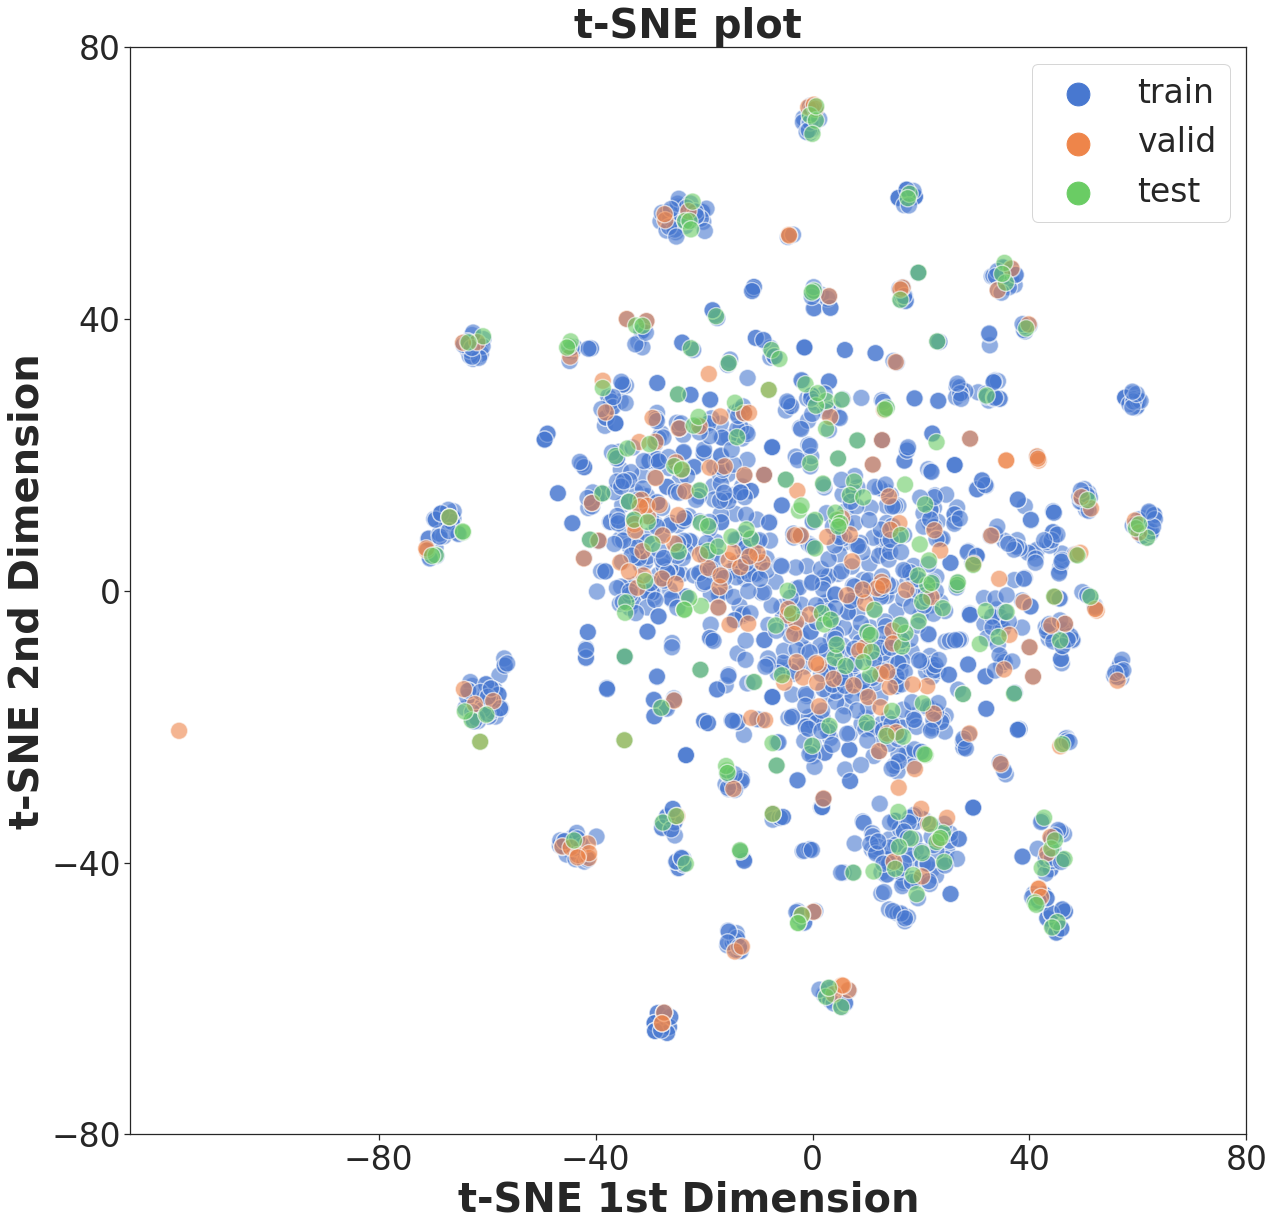

In [8]:
cp_Ld50_PFAS.visualize_plot()

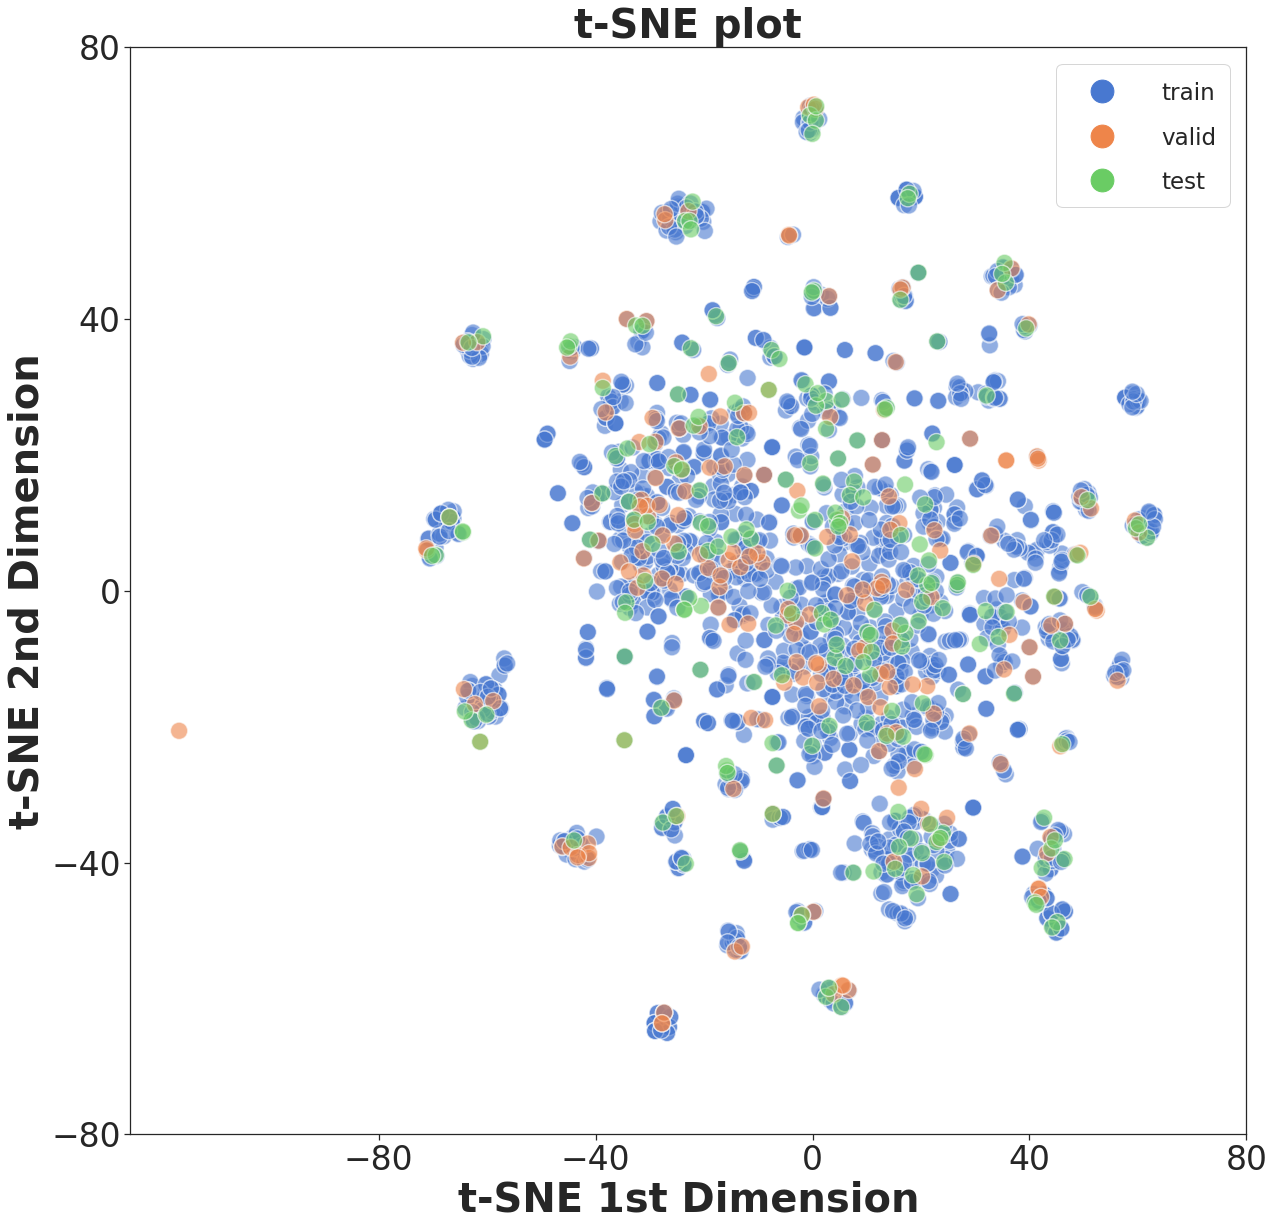

In [9]:
fig = cp_Ld50_PFAS.visualize_plot()
import matplotlib.pylab as plt
plt.legend(markerscale=20*0.19)
plt.setp(fig.get_legend().get_texts(), fontsize='23') # for legend text
plt.setp(fig.get_legend().get_title(), fontsize='23') # for legend title
plt.show()

In [7]:
fig = fig.get_figure()
fig
fig.savefig('T-SNE.png', dpi = 1200)

In [4]:
# Authors: Murat Cihan Sorkun <mcsorkun@gmail.com>, Dajt Mullaj <dajt.mullai@gmail.com>
#
# License: BSD 3 clause 
from __future__ import print_function
import descriptors as desc
import parameters as parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import base64
import functools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from pandas.api.types import is_numeric_dtype
from rdkit.Chem import Draw
from bokeh.plotting import figure
from bokeh.transform import transform, factor_cmap
from bokeh.palettes import Category10, Inferno, Spectral4
from bokeh.models.mappers import LinearColorMapper
from bokeh.models import ColorBar, HoverTool, Panel, Tabs
from bokeh.io import output_file, save, show
from scipy import stats
from io import BytesIO

def calltracker(func):
    @functools.wraps(func)
    def wrapper(*args):
        wrapper.has_been_called = True
        return func(*args)
    wrapper.has_been_called = False
    return wrapper

class Plotter(object):
    """
    A class used to plot the ECFP fingerprints of the molecules used to 
    instantiate it.
    
    :param __sim_type: similarity type structural or tailored
    :param __target_type: target type R (regression) or C (classificatino)
    :param __target: list containing the target values. Is empty if a target does not exist
    :param __mols: list of valid molecules that can be plotted
    :param __df_descriptors: datatframe containing the descriptors representation of each molecule
    :param __df_2_components: dataframe containing the two-dimenstional representation of each molecule
    :param __plot_title: title of the plot reflecting the dimensionality reduction algorithm used
    :param __data: list of the scaled descriptors to which the dimensionality reduction algorithm is applied
    :param pca_fit: PCA object created when the corresponding algorithm is applied to the data
    :param tsne_fit: t-SNE object created when the corresponding algorithm is applied to the data
    :param umap_fit: UMAP object created when the corresponding algorithm is applied to the data
    :param df_plot_xy: dataframe containing the coordinates that have been plotted
    :type __sim_type: string
    :type __target_type: string
    :type __target: list
    :type __mols: rdkit.Chem.rdchem.Mol
    :type __df_descriptors: Dataframe
    :type __df_2_components: Dataframe
    :type __plot_title: string
    :type __data: list
    :type pca_fit: sklearn.decomposition.TSNE
    :type tsne_fit: sklearn.manifold.TSNE
    :type umap_fit: umap.umap_.UMAP
    :type df_plot_xy: Dataframe
    """
       
    _static_plots = {'scatter', 'hex', 'kde'}
    
    _interactive_plots = {'scatter', 'hex'}
    
    _sim_types = {'tailored', 'structural'}
    
    _target_types = {'R', 'C'}

    def __init__(self, encoding_list, target, target_type, sim_type, get_desc, get_fingerprints):
           
        # Error handeling sym_type
        if sim_type not in self._sim_types:
            if len(target) > 0:
                self.__sim_type = 'tailored' 
                print('sim_type indicates the similarity type by which the plots are constructed.\n' +
                      'The supported similarity types are structural and tailored.\n' +
                      'Because a target list has been provided \'tailored\' as been selected as sym_type.')
            else: 
                self.__sim_type = 'structural' 
                print('sim_type indicates the similarity type by which the plots are constructed.\n' +
                      'The supported similarity types are structural and tailored.\n' +
                      'Because no target list has been provided \'structural\' as been selected as sym_type.')
        else:
            self.__sim_type = sim_type
         
        if self.__sim_type != "structural" and len(target) == 0:
            raise Exception("Target values missing")
        
        # Error handeling target_type                
        if len(target) > 0:
            if len(target) != len(encoding_list):
                raise Exception("If target is provided its length must match the instances of molecules")
                
        if len(target) > 0:
            df_target = pd.DataFrame(data=target)
            unique_targets_ratio = 1.*df_target.iloc[:, 0].nunique()/df_target.iloc[:, 0].count() < 0.05
            numeric_target = is_numeric_dtype(df_target.dtypes[0])
            if target_type == 'R' and (unique_targets_ratio or not numeric_target):
                print('Input received is \'R\' for target values that seem not continuous.')
            if target_type not in self._target_types:
                if not unique_targets_ratio and numeric_target:
                    self.__target_type = 'R'
                    print('target_type indicates if the target is a continuous variable or a class label.\n'+
                          'R stands for regression and C for classification. Input R as target type for continuous variables and C for class labels.\n'+
                          'From analysis of the target, R has been selected for target_type.')
                else:
                    self.__target_type = 'C'
                    print('target_type indicates if the target is a continuous variable or a class label.\n'+
                          'R stands for regression and C for classification. Input R as target type for continuous variables and C for class labels.\n'+
                          'From analysis of the target, C has been selected for target_type.')
            else:
                self.__target_type = target_type
        else:
            self.__target_type = None
        
        if len(target) > 0 and self.__target_type == 'C':
            df_target = pd.DataFrame(data=target)
            if df_target.iloc[:, 0].nunique() == 1:
                target = []
                self.__sim_type = "structural"
                print("Only one class found in the targets")
          
        # Instantiate Plotter class
        if self.__sim_type == "tailored":
            self.__mols, df_descriptors, target = get_desc(encoding_list, target)
            if df_descriptors.empty:
                raise Exception("Descriptors could not be computed for given molecules")
            self.__df_descriptors, self.__target = desc.select_descriptors_lasso(df_descriptors,target,kind=self.__target_type)
        elif self.__sim_type == "structural":
            self.__mols, self.__df_descriptors, self.__target = get_fingerprints(encoding_list,target,2,2048)
            
        if len(self.__mols) < 2 or len(self.__df_descriptors.columns) < 2:
            raise Exception("Plotter object cannot be instantiated for given molecules")
                
        self.__df_2_components = None
        self.__plot_title = None
            
    
    @classmethod        
    def from_smiles(cls, smiles_list, target=[], target_type=None, sim_type=None):
        """
        Class method to construct a Plotter object from a list of SMILES.
        
        :param smile_list: List of the SMILES representation of the molecules to plot.       
        :param target: target values       
        :param target_type: target type R (regression) or C (classificatino)      
        :param sim_type: similarity type structural or tailored     
        :type smile_list: list
        :type target: list
        :type target_type: string
        :type sim_type: string
        :returns: A Plotter object for the molecules given as input.
        :rtype: Plotter
        """
            
        return cls(smiles_list, target, target_type, sim_type, desc.get_mordred_descriptors, desc.get_ecfp)
            

    @classmethod
    def from_inchi(cls, inchi_list, target=[], target_type=None, sim_type=None):
        """
        Class method to construct a Plotter object from a list of InChi.
        
        :param inchi_list: List of the InChi representation of the molecules to plot.
        :type inchi_list: dict
        :param target: target values
        :type target: dict
        :param target_type: target type R (regression) or C (classificatino)
        :type target_type: string
        :param sim_type: similarity type structural or tailored 
        :type sim_type: string
        :returns: A Plotter object for the molecules given as input.
        :rtype: Plotter
        """
                
        return cls(inchi_list, target, target_type, sim_type, desc.get_mordred_descriptors_from_inchi, desc.get_ecfp_from_inchi)
        
    
    def pca(self, **kwargs):
        """
        Calculates the first 2 PCA components of the molecular descriptors.
        
        :param kwargs: Other keyword arguments are passed down to sklearn.decomposition.PCA
        :type kwargs: key, value mappings
        :returns: The dataframe containing the PCA components.
        :rtype: Dataframe
        """
        self.__data = self.__data_scaler()
        
        # Linear dimensionality reduction to 2 components by PCA
        self.pca_fit = PCA(n_components=2, **kwargs)
        first2ecpf_components = self.pca_fit.fit_transform(self.__data)
        coverage_components = self.pca_fit.explained_variance_ratio_
        
        # Create labels for the plot
        first_component = "PC-1"
        second_component = "PC-2"
        # Create a dataframe containinting the first 2 PCA components of ECFP 
        self.__df_2_components = pd.DataFrame(data = first2ecpf_components
             , columns = [first_component, second_component])
        
        self.__plot_title = "Chemical Diversity"
        
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
    
    
    def tsne(self, perplexity=None, pca=False, random_state=None, **kwargs):
        """
        Calculates the first 2 t-SNE components of the molecular descriptors.
        
        :param perplexity: perplexity value for the t-SNE model  
        :param pca: indicates if the features must be preprocessed by PCA
        :param random_state: random seed that can be passed as a parameter for reproducing the same results     
        :param kwargs: Other keyword arguments are passed down to sklearn.manifold.TSNE
        :type perplexity: int
        :type pca: boolean
        :type random_state: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the t-SNE components.
        :rtype: Dataframe
        """ 
        self.__data = self.__data_scaler()
        self.__plot_title = "t-SNE Plot"
        
        # Preprocess the data with PCA
        if pca and self.__sim_type == "structural":
            pca = PCA(n_components=10, random_state=random_state)
            self.__data = pca.fit_transform(self.__data)
            self.__plot_title = "t-SNE plot from components with cumulative variance explained " + "{:.0%}".format(sum(pca.explained_variance_ratio_))
        else:
            self.__plot_title = "t-SNE plot"
        
        # Get the perplexity of the model
        if perplexity is None:
            if self.__sim_type == "structural":
                if pca:
                    perplexity = parameters.perplexity_structural_pca(len(self.__data))
                else:
                    perplexity = parameters.perplexity_structural(len(self.__data))
            else:
                perplexity = parameters.perplexity_tailored(len(self.__data))
        else:
            if perplexity<5 or perplexity>50:
                print('Robust results are obtained for values of perplexity between 5 and 50')
        
        # Embed the data in two dimensions
        self.tsne_fit = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, **kwargs)
        ecfp_tsne_embedding = self.tsne_fit.fit_transform(self.__data)
        # Create a dataframe containinting the first 2 TSNE components of ECFP 
        self.__df_2_components = pd.DataFrame(data = ecfp_tsne_embedding
             , columns = ['t-SNE 1st Dimension', 't-SNE 2nd Dimension'])
            
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
        
        
    def umap(self, n_neighbors=None, min_dist=None, pca=False, random_state=None, **kwargs):
        """
        Calculates the first 2 UMAP components of the molecular descriptors.
        
        :param num_neighbors: Number of neighbours used in the UMAP madel.
        :param min_dist: Value between 0.0 and 0.99, indicates how close to each other the points can be displayed.
        :param random_state: random seed that can be passed as a parameter for reproducing the same results
        :param kwargs: Other keyword arguments are passed down to umap.UMAP
        :type num_neighbors: int
        :type min_dist: float
        :type random_state: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the UMAP components.
        :rtype: Dataframe
        """  
        self.__data = self.__data_scaler()
        
        # Preprocess the data with PCA
        if pca and self.__sim_type == "structural":
            pca = PCA(n_components=10, random_state=random_state)
            self.__data = pca.fit_transform(self.__data)
            self.__plot_title = "UMAP plot from components with cumulative variance explained " + "{:.0%}".format(sum(pca.explained_variance_ratio_))
        else:
            self.__plot_title = "UMAP plot"
        
        if n_neighbors is None:
            if self.__sim_type == "structural":
                if pca:
                    n_neighbors = parameters.n_neighbors_structural_pca(len(self.__data))
                else:
                    n_neighbors = parameters.n_neighbors_structural(len(self.__data))
            else:
                n_neighbors = parameters.n_neighbors_tailored(len(self.__data))
                
        if min_dist is None or min_dist < 0.0 or min_dist > 0.99:
            if min_dist is not None and (min_dist < 0.0 or min_dist > 0.99):
                print('min_dist must range from 0.0 up to 0.99. Default used.')
            if self.__sim_type == "structural":
                if pca:
                    min_dist = parameters.MIN_DIST_STRUCTURAL_PCA
                else:
                    min_dist = parameters.MIN_DIST_STRUCTURAL
            else:
                min_dist = parameters.MIN_DIST_TAILORED
            
        # Embed the data in two dimensions
        self.umap_fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_components=2, **kwargs)
        ecfp_umap_embedding = self.umap_fit.fit_transform(self.__data)
        # Create a dataframe containinting the first 2 UMAP components of ECFP 
        self.__df_2_components = pd.DataFrame(data = ecfp_umap_embedding
             , columns = ['UMAP-1', 'UMAP-2'])
        
        if len(self.__target) > 0: 
            self.__df_2_components['target'] = self.__target
        
        return self.__df_2_components.copy()
    
    
    def cluster(self, n_clusters=5, **kwargs):
        """
        Computes the clusters presents in the embedded chemical space.
        
        :param n_clusters: Number of clusters that will be computed  
        :param kwargs: Other keyword arguments are passed down to sklearn.cluster.KMeans
        :type n_clusters: int
        :type kwargs: key, value mappings
        :returns: The dataframe containing the 2D embedding.
        :rtype: Dataframe
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before clustering.')
            return None
        
        x = self.__df_2_components.columns[0]
        y = self.__df_2_components.columns[1]
        
        cluster = KMeans(n_clusters, **kwargs)
        
        cluster.fit(self.__df_2_components[[x,y]])
        self.__df_2_components['clusters'] = cluster.labels_.tolist()
        
        return self.__df_2_components.copy()
    
    
    def visualize_plot(self, size=20, kind="scatter", remove_outliers=False, is_colored=True, colorbar=False, clusters=False, filename=None, title=None):
        """
        Generates a plot for the given molecules embedded in two dimensions.
        
        :param size: Size of the plot  
        :param kind: Type of plot 
        :param remove_outliers: Boolean value indicating if the outliers must be identified and removed 
        :param is_colored: Indicates if the points must be colored according to target 
        :param colorbar: Indicates if the plot legend must be represented as a colorbar. Only considered when the target_type is "R".
        :param clusters: If True the clusters are shown instead of possible targets. Pass a list or a int to only show selected clusters (indexed by int).
        :param filename: Indicates the file where to save the plot
        :param title: Title of the plot.
        :type size: int
        :type kind: string
        :type remove_outliers: boolean
        :type is_colored: boolean
        :type colorbar: boolean
        :type clusters: boolean or list or int
        :type filename: string
        :type title: string
        :returns: The matplotlib axes containing the plot.
        :rtype: Axes
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before creating a plot.')
            return None
        
        if clusters is not False and 'clusters' not in self.__df_2_components:
            print('Call cluster() before visualizing a plot with clusters.')
        
        if title is None:
            title = self.__plot_title
        
        if kind not in self._static_plots:
            kind = 'scatter'
            print('kind indicates which type of plot must be visualized. Currently supported static visualization are:\n'+
                  '-scatter plot (scatter)\n'+
                  '-hexagon plot (hex)\n'+
                  '-kernel density estimation plot (kde)\n'+
                  'Please input one between scatter, hex or kde for parameter kind.\n'+
                  'As default scatter has been taken.')
            
        x, y, df_data = self.__parse_dataframe()
        
        # Define colors 
        hue = None
        hue_order = None
        palette = None
        if clusters is not False and 'clusters' in self.__df_2_components.columns:
            hue = 'clusters'
            palette = 'deep'
            if not isinstance(clusters, bool):
                if isinstance(clusters, int): clusters = [clusters]
                df_data['clusters'] = df_data['clusters'].isin(clusters)
                # Labels cluster
                total = df_data['clusters'].value_counts()
                t_s = total.get(True) if total.get(True) else 0
                p_s = t_s / total.sum()
                p_o = 1 - p_s
                labels = {
                    True: f'Selected - {p_s:.0%}', 
                    False: f'Other - {p_o:.0%}'
                    }
                df_data.clusters.replace(labels, inplace=True)
                hue_order = list(labels.values())
            else:
                hue_order = self.__percentage_clusters(df_data)
                hue_order.sort()
        else:
            if len(self.__target) == 0:
                is_colored = False;
            else:
                if is_colored:
                    df_data = df_data.assign(target=self.__target)
                    hue = 'target'
                    palette = 'deep'
                    if self.__target_type == "R":
                        palette = sns.color_palette("inferno", as_cmap=True)
                        
        
        # Remove outliers (using Z-score)
        if remove_outliers:
            df_data = self.__remove_outliers(x, y, df_data)
            
        # Define plot aesthetics parameters
#         sns.set_style("dark")
        sns.set(style='ticks')
        sns.set_context("notebook", font_scale=size*0.15)
        fig, ax = plt.subplots(figsize=(size,size))
        
        
        palette = 'Paired_r'
        # Create a plot based on the reduced components 
        if kind == "scatter":
#             plot = sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, palette=palette, data=df_data, s=size*3,alpha = .9)
            plot = sns.scatterplot(x=x, y=y, 
            hue=hue, 
            data=df_data,
            s=300,
            alpha=.6, 
            palette='muted')
            plot.set_label("scatter")
            axis = plot
            plot.legend(markerscale=size*0.19,loc = 'upper right')
            # Add colorbar
            if self.__target_type == "R" and colorbar:
                plot.get_legend().remove()
                norm = plt.Normalize(df_data['target'].min(), df_data['target'].max())
                cm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
                cm.set_array([])
                plot.figure.colorbar(cm)
        elif kind == "hex":
            plot = ax.hexbin(df_data[x], df_data[y], gridsize=40, cmap='Blues')
            fig.colorbar(plot, ax=ax)
            ax.set_label("hex")
            axis = ax
        elif kind == "kde":
            plot = sns.kdeplot(x=x, y=y, shade=True, data=df_data)
            plot.set_label("kde")
            axis = plot
             
        # Remove units from axis
        axis.set(yticks=(-6,-3,0,3,6))
        axis.set(xticks=(-6,-3,0,3,6))
        # Add labels
        axis.set_title(title,fontsize=size*2,fontweight ='bold')
        axis.set_xlabel(x,fontsize=size*2,fontweight ='bold')
        axis.set_ylabel(y,fontsize=size*2,fontweight ='bold')
        
        # Save plot
        if filename is not None:
            fig.savefig(filename)
            
        self.df_plot_xy = df_data[[x,y]]
        
        return axis
    
    def interactive_plot(self, size=700, kind="scatter", remove_outliers=False, is_colored=True, clusters=False, filename=None, show_plot=False, title=None,):
        """
        Generates an interactive Bokeh plot for the given molecules embedded in two dimensions.
        
        :param size: Size of the plot  
        :param kind: Type of plot 
        :param remove_outliers: Boolean value indicating if the outliers must be identified and removed 
        :param is_colored: Indicates if the points must be colored according to target 
        :param clusters: Indicates if to add a tab with the clusters if these have been computed
        :param filename: Indicates the file where to save the Bokeh plot
        :param show_plot: Immediately display the current plot. 
        :param title: Title of the plot.
        :type size: int
        :type kind: string
        :type remove_outliers: boolean
        :type is_colored: boolean
        :type cluster: boolean
        :type filename: string
        :type show_plot: boolean
        :type title: string
        :returns: The bokeh figure containing the plot.
        :rtype: Figure
        """
        if self.__df_2_components is None:
            print('Reduce the dimensions of your molecules before creating a plot.')
            return None
        
        if clusters and 'clusters' not in self.__df_2_components:
            print('Call cluster() before visualizing a plot with clusters.')
            
        if title is None:
            title = self.__plot_title
        
        if kind not in self._interactive_plots:
            kind = 'scatter'
            print('kind indicates which type of plot must be visualized. Currently supported interactive visualization are:\n'+
                  '-scatter plot (scatter)\n'+
                  '-hexagon plot (hex)\n'+
                  'Please input one between scatter, hex or kde for parameter kind.\n'+
                  'As default scatter has been taken.')
            
        x, y, df_data = self.__parse_dataframe()
        df_data['mols'] = self.__mols
        
        if len(self.__target) > 0:
            # Target exists
            if self.__target_type == 'C':
                df_data['target'] = list(map(str, self.__target))
            else:
                df_data['target'] = self.__target
            
        # Remove outliers (using Z-score)
        if remove_outliers:
            df_data = self.__remove_outliers(x, y, df_data)
        
        tabs = None
        if kind == "scatter":
            p, tabs = self.__interactive_scatter(x, y, df_data, size, is_colored, clusters, title)
        else: 
            p = self.__interactive_hex(x, y, df_data, size, title)
            
        p.xaxis[0].axis_label = x
        p.yaxis[0].axis_label = y
        
        p.xaxis.major_tick_line_color = None  
        p.xaxis.minor_tick_line_color = None
        p.yaxis.major_tick_line_color = None  
        p.yaxis.minor_tick_line_color = None 
        p.xaxis.major_label_text_font_size = '0pt'  
        p.yaxis.major_label_text_font_size = '0pt' 
        
        if tabs is not None:
            p = tabs
            
        # Save plot
        if filename is not None:
            output_file(filename, title=title)
            save(p)
        
        # Show plot
        if show_plot:
            self.__open_plot(p)
                        
        self.df_plot_xy = df_data[[x,y]]
        
        return p
    
    def __data_scaler(self):
        # Scale the data
        if self.__sim_type != "structural":
            scaled_data = StandardScaler().fit_transform(self.__df_descriptors.values.tolist())
        else:
            scaled_data = self.__df_descriptors.values.tolist()
            
        return scaled_data
    
    def __parse_dataframe(self):
        x = self.__df_2_components.columns[0]
        y = self.__df_2_components.columns[1]
        
        return x, y, self.__df_2_components.copy()
    
    def __remove_outliers(self, x, y, df):
        # Remove outliers (using Z-score)
        z_scores = stats.zscore(df[[x,y]])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 3).all(axis=1)
        
        return df[filtered_entries]
    
    def __percentage_clusters(self, df_data):
        total = df_data['clusters'].value_counts()
        sum_tot = total.sum()
        labels = {}
        count = 0
        for key, value in total.items():
            p = float(f"{(value/sum_tot)*100:.0f}")
            labels[key] = p
            count += p
        # Solve possible rounding errors
        if 100 - count > 0:
            labels[0] = labels[0] + 100 - count
        for key, value in labels.items():
            labels[key] = f"Cluster {key} - {value:.0f}%"
        # Edit df_data and return labels
        df_data.clusters.replace(labels, inplace=True)
        return list(labels.values())
            
    def __interactive_scatter(self, x, y, df_data, size, is_colored, clusters, title):       
        # Add images column
        df_data['imgs'] = self.__mol_to_2Dimage(list(df_data['mols']))
        df_data.drop(columns=['mols'], inplace=True)
        # Set tools
        tools = "pan, lasso_select, wheel_zoom, hover, save, reset"
        
        if len(self.__target) == 0:
            TOOLTIPS = parameters.TOOLTIPS_NO_TARGET
        else:
            TOOLTIPS = parameters.TOOLTIPS_TARGET

        # Create plot
        p = figure(title=title, plot_width=size, plot_height=size, tools=tools, tooltips=TOOLTIPS)
        
        if len(self.__target) == 0 or not(is_colored):
            p.circle(x=x, y=y, size=2.5, alpha=0.8, source=df_data)
        else:
            # Target exists
            if self.__target_type == 'C':
                index_cmap = factor_cmap('target', Category10[10], list(set(df_data['target'])))
                p.circle(x=x, y=y, size=2.5, alpha=0.8, line_color=index_cmap, fill_color=index_cmap,
                     legend_group="target", source=df_data)
                p.legend.location = "top_left"
                p.legend.title = "Target"
            else:
                color_mapper = LinearColorMapper(Inferno[256], low=min(df_data['target']), high=max(df_data['target']))
                index_cmap = transform('target', color_mapper)
                p.circle(x=x, y=y, size=2.5, alpha=0.8, line_color=index_cmap, fill_color=index_cmap,
                     source=df_data)
                color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
                p.add_layout(color_bar, 'right')
        
        tabs = None
        if clusters and 'clusters' in df_data.columns:
            p_c = figure(title=title, plot_width=size, plot_height=size, tools=tools, tooltips=parameters.TOOLTIPS_CLUSTER)
            # Get percentages
            self.__percentage_clusters(df_data)
            clusters = df_data.groupby(['clusters'])
            for cluster, color in zip(clusters, Category10[10]):
                p_c.circle(x=x, y=y, size=2.5, alpha=1, line_color=color, fill_color=color,
                     legend_label=f'{cluster[0]}', muted_color=('#717375'), muted_alpha=0.2,
                     source=cluster[1])
                
            p_c.legend.location = "top_left"
            p_c.legend.title = "Clusters"
            p_c.legend.click_policy = "mute"
            
            p_c.xaxis[0].axis_label = x
            p_c.yaxis[0].axis_label = y
            
            p_c.xaxis.major_tick_line_color = None  
            p_c.xaxis.minor_tick_line_color = None
            p_c.yaxis.major_tick_line_color = None  
            p_c.yaxis.minor_tick_line_color = None 
            p_c.xaxis.major_label_text_font_size = '0pt'  
            p_c.yaxis.major_label_text_font_size = '0pt' 
            
            tab1 = Panel(child=p, title="Plot")
            tab2 = Panel(child=p_c, title="Clusters")
            tabs = Tabs(tabs=[tab1, tab2])
        
        return p, tabs
                
    def __interactive_hex(self, x, y, df_data, size, title):      
        # Hex Plot
        df_data.drop(columns=['mols'], inplace=True)
        
        tools = "pan, wheel_zoom, save, reset"

        p = figure(title=title, plot_width=size, plot_height=size, match_aspect=True,
           tools=tools)
        p.background_fill_color = '#440154'
        p.grid.visible = False
            
        max_x = max(df_data[x])
        min_x = min(df_data[x])
        max_y = max(df_data[y])
        min_y = min(df_data[y])
        
        diff_x = max_x - min_x
        diff_y = max_y - min_y
        size = max(diff_y, diff_x) / 20
        
        p.hexbin(df_data[x], df_data[y], size=size, hover_color="pink", hover_alpha=0.8)
        
        hover = HoverTool(tooltips=[("count", "@c")])
        p.add_tools(hover)
        
        return p
    
    def __mol_to_2Dimage(self, list_mols):
        # Create molecule images  
        images_mol=[]          
        for mol in list_mols:
            
            try:
                png = Draw.MolToImage(mol,size=(200,130))
                out = BytesIO()
                png.save(out, format='jpeg')
                png = out.getvalue()
                url = 'data:image/jpeg;base64,' + base64.b64encode(png).decode('utf-8')
            except:
                url = None
                
            images_mol.append(url)
            
        return images_mol
    
    @calltracker
    def __open_plot(self, p):
        show(p)
    
    def get_target(self):
        return self.__target

The following erroneous SMILES have been found in the data:
smiles.
The erroneous SMILES will be removed from the data.


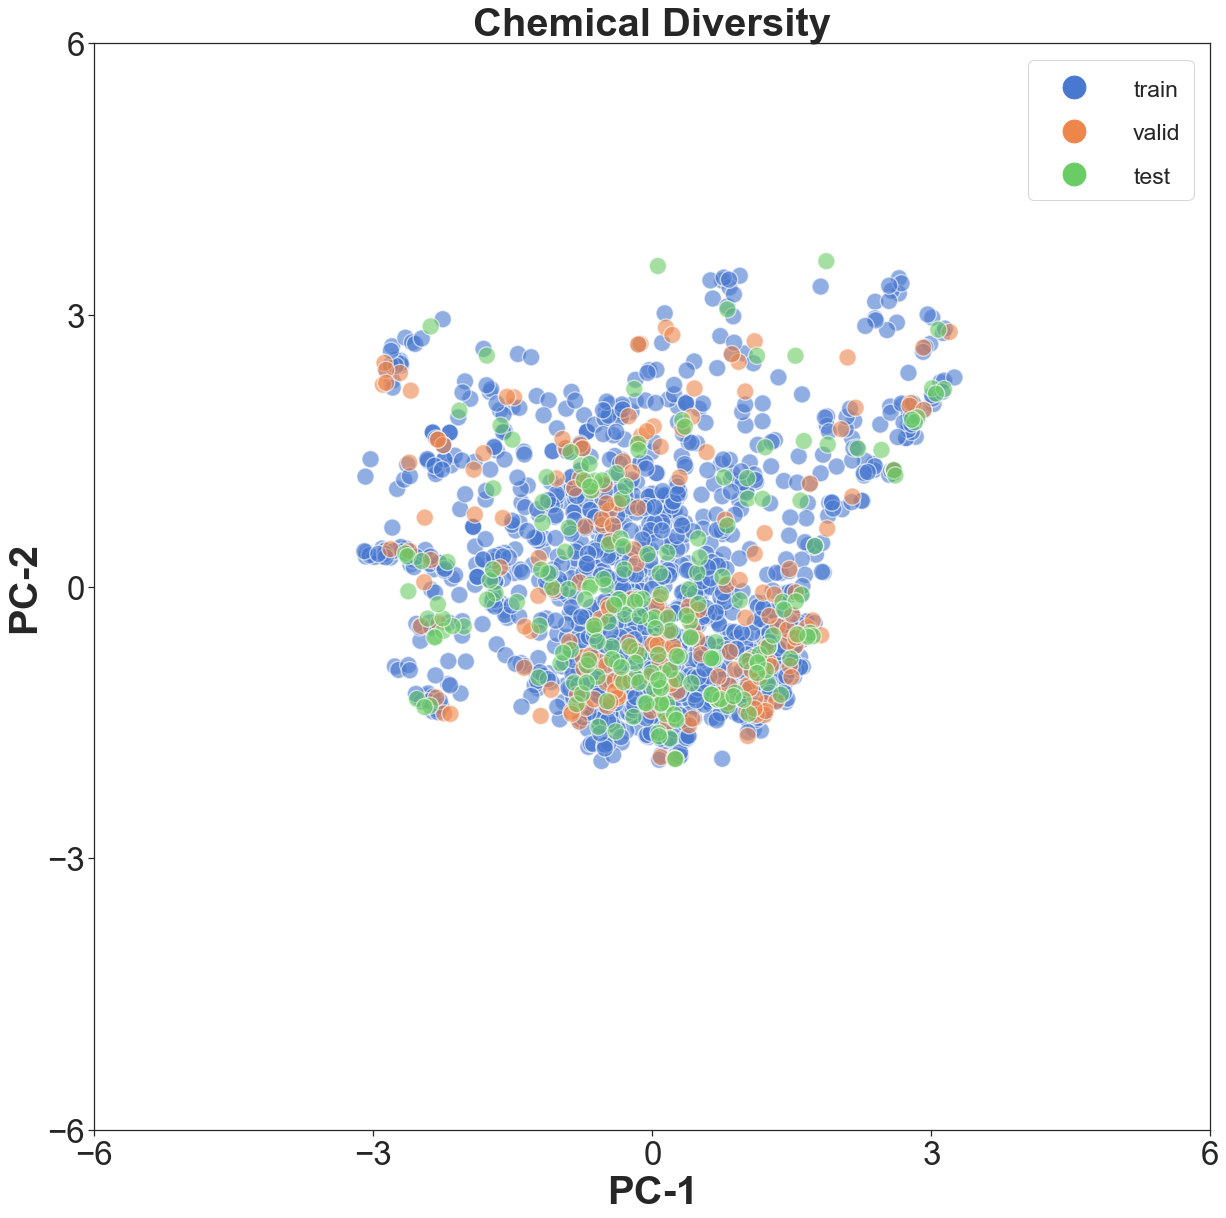

In [5]:
df_Desc = pd.read_csv('1111.csv')
df_Desc
cp_neutox = Plotter.from_smiles(df_Desc["smiles"], target=df_Desc["Cla"], target_type="C",sim_type="structural")
tsneResult = cp_neutox.pca()
fig = cp_Ld50_PFAS.visualize_plot()
import matplotlib.pylab as plt
plt.legend(markerscale=20*0.19)
plt.setp(fig.get_legend().get_texts(), fontsize='23') # for legend text
plt.setp(fig.get_legend().get_title(), fontsize='23') # for legend title
plt.show()

In [6]:
fig = fig.get_figure()
fig
fig.savefig('PCA.png', dpi = 1200)